In [2]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import nibabel as nib



In [3]:
# check segmentation files
segmentation_dir = "../../datasets/Craig_scans/segmentation"
segmentation_files = [f for f in os.listdir(segmentation_dir) 
                   if f.endswith('.nii.gz') or f.endswith('.nii')]
# load the masks
masks = [nib.load(os.path.join(segmentation_dir, mask_file)).get_fdata() for mask_file in segmentation_files]
for mask in masks:
    print(f"shape={mask.shape}, sum={np.sum(mask)}")


shape=(256, 256, 120), sum=97854000.0
shape=(256, 256, 120), sum=98515800.0
shape=(256, 256, 120), sum=98325950.0
shape=(256, 256, 120), sum=98267050.0
shape=(256, 256, 120), sum=98403800.0
shape=(256, 256, 120), sum=98395150.0


In [4]:
def extract_date_from_filename(filepath: str) -> str:
    """Extract date in YYYYMMDD format from a file path.
    
    Args:
        filepath: Path to the file containing a date
        
    Returns:
        str: Date in YYYYMMDD format
        
    Example:
        >>> path = '../datasets/Craig_scans/20130801/HumanStabiltiy_130801_4_1.PAR'
        >>> extract_date_from_filename(path)
        '20130801'
    """
    import re
    
    # Extract 8 consecutive digits that represent a date (YYYYMMDD)
    match = re.search(r'20\d{6}', filepath)
    if match:
        return match.group(0)
    else:
        raise ValueError(f"Could not find date in filepath: {filepath}")

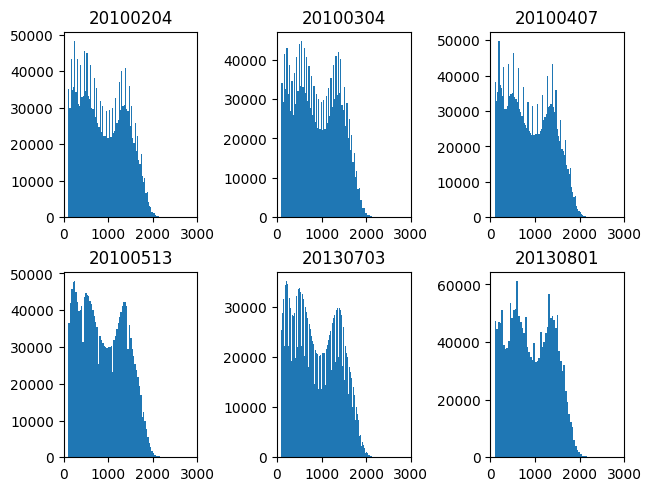

In [5]:
# draw histogram of the t1_scans before the harmonization
num_bins = 200
image_dir = "../../datasets/Craig_scans/T1_nifti"
image_files = [f for f in os.listdir(image_dir) 
                   if f.endswith('.nii.gz') or f.endswith('.nii')]
dates = [extract_date_from_filename(image_file) for image_file in image_files]
sorted_image_files = [x for _, x in sorted(zip(dates, image_files))]
filter_threshold = 100
fig, axs = plt.subplots(2, 3, constrained_layout=True)
cnt = 0 
for file_name in sorted_image_files:
    image_file = os.path.join(image_dir, file_name)
    seg_file = os.path.join(segmentation_dir, file_name)
    img = nib.load(image_file).get_fdata()
    mask = nib.load(seg_file).get_fdata()
    scan_data = img[mask > 0]
    scan_date = extract_date_from_filename(image_file)
    # Filter values greater than 100
    filtered_data = scan_data[scan_data > filter_threshold].flatten()
    # print(f"Shape: {data.shape}, Values > {filter_threshold}: {len(filtered_data)}")

    axs[cnt//3, cnt%3].hist(filtered_data, bins=num_bins)
    axs[cnt//3, cnt%3].set_title(scan_date)
    # axs[cnt//3, cnt%3].set_xlabel('Signal Intensity')
    # axs[cnt//3, cnt%3].set_ylabel('Frequency')
    axs[cnt//3, cnt%3].set_xlim(0, 3000)
    cnt += 1

plt.show()

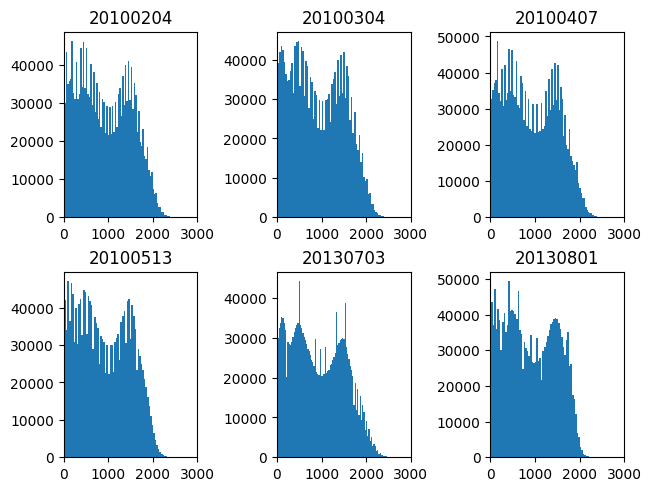

In [6]:
from intensity_normalization.normalize.nyul import NyulNormalize
import numpy as np
# t1_images = [nib.load(par_file).get_fdata() for par_file in t1_scans.values()]
# filtered_images = [data[data > filter_threshold] for data in t1_images]
filtered_images = []
scan_paths = []
for file_name in sorted_image_files:
    image_file = os.path.join(image_dir, file_name)
    seg_file = os.path.join(segmentation_dir, file_name)
    img = nib.load(image_file).get_fdata()
    mask = nib.load(seg_file).get_fdata()
    data = img[mask > 0]
    filtered_data = data[data > filter_threshold].flatten()
    scan_date = extract_date_from_filename(image_file)
    filtered_images.append(filtered_data)
    scan_paths.append(scan_date)


# print(len(filtered_images))
normalizer = NyulNormalize(min_percentile=1, max_percentile=99.99, 
                           output_min_value=0, output_max_value=3000)
normalizer.fit(filtered_images)

normalized_images = []
for image in filtered_images:
    normalized_image = normalizer(image)
    # values_below_threshold = np.sum(image < filter_threshold)
    # print(f"Values below threshold for the filtered image: {values_below_threshold}")
    normalized_images.append(normalized_image)
    # values_below_threshold = np.sum(normalized_image < filter_threshold)
    # print(f"Values below threshold for the normalized image: {values_below_threshold}")


# draw histogram of the normalized images
fig, axs = plt.subplots(2, 3, constrained_layout=True)
cnt = 0 
for idx, normalized_image in enumerate(normalized_images):
    axs[cnt//3, cnt%3].hist(normalized_image.flatten(), bins=num_bins)
    axs[cnt//3, cnt%3].set_title(scan_paths[idx])
    axs[cnt//3, cnt%3].set_xlim(0, 3000)
    cnt += 1
plt.show()

